## Importing of Libraries + .csv

In [ ]:

from __future__ import annotations
import numpy as np
import pandas as pd
import re
from math import sqrt
from pathlib import Path
from typing import Tuple, Dict, List
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_validate, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance

try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
    IMB = True
except Exception:
    IMB = False

In [ ]:
%%capture
%%bash
wget https://github.com/leec0140/NYP105/raw/main/safety_monitoring.csv
wget https://github.com/leec0140/NYP105/raw/main/health_monitoring.csv
wget https://github.com/leec0140/NYP105/raw/main/daily_reminder.csv

In [ ]:
SAFETY_CSV   = 'safety_monitoring.csv'
HEALTH_CSV   = 'health_monitoring.csv'
REMINDER_CSV = 'daily_reminder.csv'

RANDOM_STATE = 42
MERGE_TOLERANCE_SEC = 120  # when combining by nearest timestamp (± seconds)
INACTIVITY_THRESHOLD_SEC = 600  # anomaly rule: extended inactivity >= 10 minutes

pd.set_option("display.max_colwidth", 120)

### First run

In [ ]:
# %% 2) LOADERS, CLEANING, MERGE HELPERS

def _clean(df: pd.DataFrame) -> pd.DataFrame:
    df = df.loc[:, ~df.columns.str.contains("^Unnamed")]
    df.columns = [c.strip() for c in df.columns]
    if "Device-ID/User-ID" in df.columns:
        df = df.rename(columns={"Device-ID/User-ID": "DeviceUserID"})
    return df

def _parse_ts(df: pd.DataFrame, col: str = "Timestamp") -> pd.DataFrame:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce", infer_datetime_format=True)
    return df

def load_raw() -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    safety   = _parse_ts(_clean(pd.read_csv(SAFETY_CSV)))
    health   = _parse_ts(_clean(pd.read_csv(HEALTH_CSV)))
    reminder = _parse_ts(_clean(pd.read_csv(REMINDER_CSV)))
    return safety, health, reminder

def basic_filters(safety: pd.DataFrame, health: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    # Safety must have usable timestamps
    safety = safety.dropna(subset=["Timestamp"])
    # Simple outlier guards for health signals
    if "Heart Rate" in health.columns:
        health = health[(health["Heart Rate"] >= 30) & (health["Heart Rate"] <= 220)]
    if "Oxygen Saturation (SpO₂%)" in health.columns:
        health = health[(health["Oxygen Saturation (SpO₂%)"] >= 70) & (health["Oxygen Saturation (SpO₂%)"] <= 100)]
    return safety, health

def _sort_clean(df: pd.DataFrame) -> pd.DataFrame:
    return df.dropna(subset=["DeviceUserID", "Timestamp"]).sort_values(["DeviceUserID","Timestamp"]).reset_index(drop=True)

def merge_nearest_by_device(base: pd.DataFrame, right: pd.DataFrame, tolerance_sec: int) -> pd.DataFrame:
    tol = pd.Timedelta(seconds=tolerance_sec)
    merged_chunks = []
    for dev, g in base.groupby("DeviceUserID"):
        r = right[right["DeviceUserID"] == dev]
        mg = pd.merge_asof(g, r, on="Timestamp", direction="nearest", tolerance=tol)
        merged_chunks.append(mg)
    out = pd.concat(merged_chunks, ignore_index=True)
    # drop any duplicate col names (keep first)
    out = out.loc[:, ~out.columns.duplicated(keep="first")]
    return out


In [ ]:
# %% 3) FEATURE UTILS & PREPROCESSOR

def add_time_features(X: pd.DataFrame) -> pd.DataFrame:
    out = X.copy()
    if "Timestamp" in out.columns:
        s = pd.to_datetime(out["Timestamp"], errors="coerce")
        out["hour"] = s.dt.hour
        out["dow"]  = s.dt.dayofweek
    return out

def make_preprocessor(X: pd.DataFrame) -> Tuple[ColumnTransformer, pd.DataFrame, List[str], List[str], List[str]]:
    X2 = add_time_features(X)
    numeric_cols = X2.select_dtypes(include=["number"]).columns.tolist()
    time_cols = [c for c in X2.columns if "Timestamp" in c]
    cat_cols = [c for c in X2.columns if c not in numeric_cols + time_cols]

    num_tf = Pipeline([("imp", SimpleImputer(strategy="median")),
                       ("scaler", StandardScaler())])
    cat_tf = Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                       ("oh", OneHotEncoder(handle_unknown="ignore"))])

    pre = ColumnTransformer([("num", num_tf, numeric_cols),
                             ("cat", cat_tf, cat_cols)])
    return pre, X2, numeric_cols, cat_cols, time_cols


In [ ]:
# %% 4) PART 1 — ASSESS: use separate CSVs or combine?

def build_variants_for_activity() -> Dict[str, Tuple[pd.DataFrame, pd.Series]]:
    """Returns datasets (X,y) for activity classification under different data sources."""
    safety, health, reminder = load_raw()
    safety, health = basic_filters(safety, health)

    # A) safety-only (label present here)
    yA = safety["Movement Activity"].dropna()
    XA = safety.loc[yA.index].drop(columns=["Movement Activity"])

    # B) combined: safety + nearest health + nearest reminder
    base = _sort_clean(safety.copy())
    health2 = _sort_clean(health.copy())
    reminder2 = _sort_clean(reminder.copy())

    # Check if 'DeviceUserID' exists before merging
    if 'DeviceUserID' in base.columns and 'DeviceUserID' in health2.columns:
        comb = merge_nearest_by_device(base, health2, MERGE_TOLERANCE_SEC)
        if 'DeviceUserID' in comb.columns and 'DeviceUserID' in reminder2.columns:
             comb = merge_nearest_by_device(comb, reminder2, MERGE_TOLERANCE_SEC)
        else:
             print("Warning: 'DeviceUserID' not found in combined dataframe or reminder dataframe. Skipping merge with reminder.")
    else:
         print("Warning: 'DeviceUserID' not found in base or health dataframe. Skipping merge with health and reminder.")
         comb = base.copy() # Keep base data if merge not possible


    yB = comb["Movement Activity"].dropna()
    XB = comb.loc[yB.index].drop(columns=["Movement Activity"])

    # (Health-only or Reminder-only are generally not labeled for activity; skip to avoid leakage.)
    return {"safety_only": (XA, yA), "combined": (XB, yB)}

def build_variants_for_anomaly() -> Dict[str, Tuple[pd.DataFrame, pd.Series]]:
    """Create binary anomaly label: Fall==Yes OR inactivity >= threshold."""
    safety, health, reminder = load_raw()
    safety, health = basic_filters(safety, health)

    def label_anomaly(df: pd.DataFrame) -> pd.Series:
        fall_col = "Fall Detected (Yes/No)"
        inact_col = "Post-Fall Inactivity Duration (Seconds)"
        fall_yes = df.get(fall_col, pd.Series(index=df.index, dtype=object)).astype(str).str.lower().eq("yes")
        long_inact = pd.to_numeric(df.get(inact_col, pd.Series(index=df.index)), errors="coerce").fillna(0) >= INACTIVITY_THRESHOLD_SEC
        return (fall_yes | long_inact).astype(int)

    # A) safety-only
    yA = label_anomaly(safety)
    XA = safety.drop(columns=[c for c in ["Movement Activity"] if c in safety.columns])

    # B) combined
    base = _sort_clean(safety.copy())
    health2 = _sort_clean(health.copy())
    reminder2 = _sort_clean(reminder.copy())

    # Check if 'DeviceUserID' exists before merging
    if 'DeviceUserID' in base.columns and 'DeviceUserID' in health2.columns:
        comb = merge_nearest_by_device(base, health2, MERGE_TOLERANCE_SEC)
        if 'DeviceUserID' in comb.columns and 'DeviceUserID' in reminder2.columns:
             comb = merge_nearest_by_device(comb, reminder2, MERGE_TOLERANCE_SEC)
        else:
             print("Warning: 'DeviceUserID' not found in combined dataframe or reminder dataframe. Skipping merge with reminder.")
    else:
         print("Warning: 'DeviceUserID' not found in base or health dataframe. Skipping merge with health and reminder.")
         comb = base.copy() # Keep base data if merge not possible


    yB = label_anomaly(comb)
    XB = comb.drop(columns=[c for c in ["Movement Activity"] if c in comb.columns])

    return {"safety_only": (XA, yA), "combined": (XB, yB)}

def quick_model_compare(X: pd.DataFrame, y: pd.Series, note:str, use_smote=False) -> pd.DataFrame:
    """Run a quick 5-fold CV over several models and return metrics."""
    pre, X2, *_ = make_preprocessor(X)
    Pipe = ImbPipeline if (use_smote) else Pipeline

    models = {
        "LogReg": LogisticRegression(max_iter=400, class_weight="balanced"),
        "RF": RandomForestClassifier(n_estimators=300, class_weight="balanced_subsample", random_state=RANDOM_STATE),
        "SVC": SVC(probability=True, class_weight="balanced", random_state=RANDOM_STATE),
        "KNN": KNeighborsClassifier(n_neighbors=7),
        "GB": GradientBoostingClassifier(random_state=RANDOM_STATE),
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    scoring = {"acc":"accuracy","f1w":"f1_weighted","precw":"precision_weighted","recw":"recall_weighted"}

    rows = []
    for name, clf in models.items():
        steps = [("pre", pre)]
        if use_smote:
            steps.append(("smote", SMOTE(random_state=RANDOM_STATE)))
        steps.append(("clf", clf))
        pipe = Pipe(steps)
        cv = cross_validate(pipe, X2, y, cv=skf, n_jobs=-1, scoring=scoring)
        rows.append({"variant": note, "model": name,
                     "f1w": np.mean(cv["test_f1w"]),
                     "acc": np.mean(cv["test_acc"]),
                     "precw": np.mean(cv["test_precw"]),
                     "recw": np.mean(cv["test_recw"])})
    return pd.DataFrame(rows).sort_values(["f1w","acc"], ascending=False).reset_index(drop=True)

# ---- Run assessment for both tasks
act_variants = build_variants_for_activity()
anom_variants = build_variants_for_anomaly()

print("Activity Classification — Evaluate variants:")
act_results = []
for vname, (X, y) in act_variants.items():
    res = quick_model_compare(X, y, note=f"activity:{vname}", use_smote=False)
    act_results.append(res)
act_results = pd.concat(act_results, ignore_index=True)
display(act_results.head(10))

print("\nAnomaly Detection — Evaluate variants:")
anom_results = []
for vname, (X, y) in anom_variants.items():
    res = quick_model_compare(X, y, note=f"anomaly:{vname}", use_smote=False)
    anom_results.append(res)
anom_results = pd.concat(anom_results, ignore_index=True)
display(anom_results.head(10))

# Decision rule: keep the variant (safety_only vs combined) that gives better F1-weighted.
best_act_variant = (act_results.groupby("variant")["f1w"].mean().idxmax()).split(":")[1]
best_anom_variant = (anom_results.groupby("variant")["f1w"].mean().idxmax()).split(":")[1]
print(f"\nChosen for ACTIVITY: {best_act_variant}")
print(f"Chosen for ANOMALY:  {best_anom_variant}")

/tmp/ipython-input-173897900.py:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[col] = pd.to_datetime(df[col], errors="coerce", infer_datetime_format=True)
/tmp/ipython-input-173897900.py:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[col] = pd.to_datetime(df[col], errors="coerce", infer_datetime_format=True)
/tmp/ipython-input-173897900.py:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-d

/tmp/ipython-input-173897900.py:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[col] = pd.to_datetime(df[col], errors="coerce", infer_datetime_format=True)
/tmp/ipython-input-173897900.py:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[col] = pd.to_datetime(df[col], errors="coerce", infer_datetime_format=True)
/tmp/ipython-input-173897900.py:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-d

Activity Classification — Evaluate variants:


,variant,model,f1w,acc,precw,recw
0,activity:safety_only,SVC,0.304896,0.3058,0.452075,0.3058
1,activity:safety_only,RF,0.304177,0.3011,0.416862,0.3011
2,activity:safety_only,LogReg,0.300411,0.3050,0.448721,0.3050
3,activity:safety_only,KNN,0.285952,0.2889,0.292071,0.2889
4,activity:safety_only,GB,0.273006,0.2977,0.439395,0.2977
5,activity:combined,RF,0.304721,0.3013,0.419602,0.3013
6,activity:combined,LogReg,0.300381,0.3042,0.450571,0.3042
7,activity:combined,SVC,0.297908,0.3042,0.450152,0.3042
8,activity:combined,KNN,0.283398,0.2861,0.287456,0.2861
9,activity:combined,GB,0.268445,0.2994,0.432948,0.2994



Anomaly Detection — Evaluate variants:


,variant,model,f1w,acc,precw,recw
0,anomaly:safety_only,LogReg,1.0000,1.0000,1.000000,1.0000
1,anomaly:safety_only,RF,1.0000,1.0000,1.000000,1.0000
2,anomaly:safety_only,SVC,1.0000,1.0000,1.000000,1.0000
3,anomaly:safety_only,KNN,1.0000,1.0000,1.000000,1.0000
4,anomaly:safety_only,GB,1.0000,1.0000,1.000000,1.0000
5,anomaly:combined,LogReg,1.0000,1.0000,1.000000,1.0000
6,anomaly:combined,RF,1.0000,1.0000,1.000000,1.0000
7,anomaly:combined,KNN,1.0000,1.0000,1.000000,1.0000
8,anomaly:combined,GB,1.0000,1.0000,1.000000,1.0000
9,anomaly:combined,SVC,0.9998,0.9998,0.999802,0.9998



Chosen for ACTIVITY: safety_only
Chosen for ANOMALY:  safety_only


In [ ]:
# %% 5) PART 2 — DATA PREP (missing values, types, outliers, class balancing) + FEATURE ENGINEERING

def prepare_dataset(task: str, chosen_variant: str) -> Tuple[pd.DataFrame, pd.Series]:
    assert task in {"activity", "anomaly"}
    if task == "activity":
        variants = build_variants_for_activity()
        X, y = variants[chosen_variant]
        # y already multi-class labels (Movement Activity)
    else:
        variants = build_variants_for_anomaly()
        X, y = variants[chosen_variant]
        y = y.astype(int)   # binary 0/1

    return X, y

# Build final datasets for both tasks using the chosen variant
X_act, y_act = prepare_dataset("activity", best_act_variant)
X_anom, y_anom = prepare_dataset("anomaly",  best_anom_variant)

print("Activity:", X_act.shape, "classes:", y_act.nunique())
print("Anomaly :", X_anom.shape, "classes:", y_anom.nunique())


/tmp/ipython-input-173897900.py:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[col] = pd.to_datetime(df[col], errors="coerce", infer_datetime_format=True)
/tmp/ipython-input-173897900.py:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[col] = pd.to_datetime(df[col], errors="coerce", infer_datetime_format=True)
/tmp/ipython-input-173897900.py:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-d

/tmp/ipython-input-173897900.py:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[col] = pd.to_datetime(df[col], errors="coerce", infer_datetime_format=True)
/tmp/ipython-input-173897900.py:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[col] = pd.to_datetime(df[col], errors="coerce", infer_datetime_format=True)
/tmp/ipython-input-173897900.py:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-d

Activity: (10000, 8) classes: 4
Anomaly : (10000, 8) classes: 2


In [ ]:
# %% 6) PART 3 — MODEL SWEEP & SELECTION (pick best by F1-weighted)

def model_sweep(X: pd.DataFrame, y: pd.Series, task_name: str, use_smote: bool=False) -> pd.DataFrame:
    pre, X2, *_ = make_preprocessor(X)
    Pipe = ImbPipeline if (use_smote) else Pipeline

    models = {
        "LogReg": LogisticRegression(max_iter=400, class_weight="balanced"),
        "RF": RandomForestClassifier(n_estimators=300, class_weight="balanced_subsample", random_state=RANDOM_STATE),
        "SVC": SVC(probability=True, class_weight="balanced", random_state=RANDOM_STATE),
        "KNN": KNeighborsClassifier(n_neighbors=7),
        "GB": GradientBoostingClassifier(random_state=RANDOM_STATE),
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    scoring = {"acc":"accuracy","f1w":"f1_weighted","precw":"precision_weighted","recw":"recall_weighted"}

    rows = []
    for name, clf in models.items():
        steps = [("pre", pre)]
        if use_smote:
            steps.append(("smote", SMOTE(random_state=RANDOM_STATE)))
        steps.append(("clf", clf))
        pipe = Pipe(steps)
        cv = cross_validate(pipe, X2, y, cv=skf, n_jobs=-1, scoring=scoring)
        rows.append({"task": task_name, "model": name,
                     "f1w": np.mean(cv["test_f1w"]),
                     "acc": np.mean(cv["test_acc"]),
                     "precw": np.mean(cv["test_precw"]),
                     "recw": np.mean(cv["test_recw"])})
    return pd.DataFrame(rows).sort_values(["f1w","acc"], ascending=False).reset_index(drop=True)

act_sweep = model_sweep(X_act, y_act, "activity", use_smote=False)
anom_sweep = model_sweep(X_anom, y_anom, "anomaly",  use_smote=False)

display(act_sweep.head(10))
display(anom_sweep.head(10))

best_act_model_name  = act_sweep.iloc[0]["model"]
best_anom_model_name = anom_sweep.iloc[0]["model"]
print("Best activity model:", best_act_model_name)
print("Best anomaly  model:", best_anom_model_name)


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,task,model,f1w,acc,precw,recw
0,activity,SVC,0.304896,0.3058,0.452075,0.3058
1,activity,RF,0.304177,0.3011,0.416862,0.3011
2,activity,LogReg,0.300411,0.3050,0.448721,0.3050
3,activity,KNN,0.285952,0.2889,0.292071,0.2889
4,activity,GB,0.273006,0.2977,0.439395,0.2977


,task,model,f1w,acc,precw,recw
0,anomaly,LogReg,1.0,1.0,1.0,1.0
1,anomaly,RF,1.0,1.0,1.0,1.0
2,anomaly,SVC,1.0,1.0,1.0,1.0
3,anomaly,KNN,1.0,1.0,1.0,1.0
4,anomaly,GB,1.0,1.0,1.0,1.0


Best activity model: SVC
Best anomaly  model: LogReg


In [ ]:
# %% 7) PART 4 — HYPERPARAMETER TUNING on the best model

def tune_best(X: pd.DataFrame, y: pd.Series, best_name: str):
    pre, X2, *_ = make_preprocessor(X)

    if best_name == "RF":
        base = RandomForestClassifier(class_weight="balanced_subsample", random_state=RANDOM_STATE)
        grid = {
            "clf__n_estimators": [200, 300, 400, 600, 800],
            "clf__max_depth": [None, 5, 10, 20],
            "clf__min_samples_split": [2, 5, 10],
            "clf__min_samples_leaf": [1, 2, 5],
        }
    elif best_name == "SVC":
        base = SVC(probability=True, class_weight="balanced", random_state=RANDOM_STATE)
        grid = {
            "clf__C": np.logspace(-2, 2, 12),
            "clf__gamma": ["scale", "auto"],
            "clf__kernel": ["rbf", "poly"]
        }
    elif best_name == "GB":
        base = GradientBoostingClassifier(random_state=RANDOM_STATE)
        grid = {
            "clf__n_estimators": [100, 200, 300],
            "clf__learning_rate": [0.01, 0.05, 0.1, 0.2],
            "clf__max_depth": [2, 3, 4],
        }
    elif best_name == "LogReg":
        base = LogisticRegression(max_iter=600, class_weight="balanced")
        grid = {
            "clf__C": np.logspace(-3, 2, 8),
            "clf__penalty": ["l2"],
        }
    else:  # KNN
        base = KNeighborsClassifier()
        grid = {
            "clf__n_neighbors": [3, 5, 7, 9, 11],
            "clf__weights": ["uniform", "distance"],
        }

    pipe = Pipeline([("pre", pre), ("clf", base)])
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=grid,
        n_iter=24,
        scoring="f1_weighted",
        cv=skf,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbose=1
    )
    search.fit(X2, y)
    return search.best_estimator_, search.best_params_, search.best_score_

best_act_est, act_params, act_f1 = tune_best(X_act, y_act, best_act_model_name)
best_anom_est, anom_params, anom_f1 = tune_best(X_anom, y_anom, best_anom_model_name)

print("\nActivity — best CV F1:", round(act_f1,4), "| params:", act_params)
print("Anomaly  — best CV F1:",  round(anom_f1,4), "| params:", anom_params)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=24. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 8 candidates, totalling 40 fits

Activity — best CV F1: 0.3055 | params: {'clf__kernel': 'poly', 'clf__gamma': 'scale', 'clf__C': np.float64(8.111308307896872)}
Anomaly  — best CV F1: 1.0 | params: {'clf__penalty': 'l2', 'clf__C': np.float64(0.005179474679231213)}


In [ ]:
# %% 8) Holdout validation for tuned models

def holdout_report(estimator: Pipeline, X: pd.DataFrame, y: pd.Series, title: str):
    pre, X2, *_ = make_preprocessor(X)
    # If estimator already includes the preprocessor (it does), just fit it:
    X_tr, X_va, y_tr, y_va = train_test_split(X2, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
    estimator.fit(X_tr, y_tr)
    y_pred = estimator.predict(X_va)
    print(f"\n=== {title}: Holdout Classification Report ===")
    print(classification_report(y_va, y_pred))

holdout_report(best_act_est,  X_act,  y_act,  "Activity")
holdout_report(best_anom_est, X_anom, y_anom, "Anomaly")



=== Activity: Holdout Classification Report ===
              precision    recall  f1-score   support

       Lying       0.26      0.31      0.28       497
 No Movement       0.95      0.21      0.34       499
     Sitting       0.27      0.32      0.30       506
     Walking       0.27      0.38      0.32       498

    accuracy                           0.31      2000
   macro avg       0.44      0.31      0.31      2000
weighted avg       0.44      0.31      0.31      2000


=== Anomaly: Holdout Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1900
           1       1.00      1.00      1.00       100

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [ ]:
# %% 9) PART 5 — ENSEMBLES: Voting & Stacking (compare to tuned single model)

def evaluate_ensembles(X: pd.DataFrame, y: pd.Series, tuned_best: Pipeline, name_best: str) -> pd.DataFrame:
    pre, X2, *_ = make_preprocessor(X)

    # Base learners (simple, strong mix)
    lr  = LogisticRegression(max_iter=400, class_weight="balanced")
    rf  = RandomForestClassifier(n_estimators=300, class_weight="balanced_subsample", random_state=RANDOM_STATE)
    svc = SVC(probability=True, class_weight="balanced", random_state=RANDOM_STATE)

    voting = VotingClassifier(estimators=[("lr", lr), ("rf", rf), ("svc", svc)], voting="soft")
    stack  = StackingClassifier(estimators=[("lr", lr), ("rf", rf), ("svc", svc)],
                                final_estimator=LogisticRegression(max_iter=400))

    models = {
        "TunedBest("+name_best+")": tuned_best,
        "Voting(LR+RF+SVC)": Pipeline([("pre", pre), ("clf", voting)]),
        "Stacking(LR+RF+SVC→LR)": Pipeline([("pre", pre), ("clf", stack)])
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    scoring = {"acc":"accuracy","f1w":"f1_weighted","precw":"precision_weighted","recw":"recall_weighted"}

    rows = []
    for mname, est in models.items():
        # Ensure preprocess is included (tuned_best already contains it)
        if mname.startswith("TunedBest"):
            est_to_cv = est
        else:
            est_to_cv = est
        cv = cross_validate(est_to_cv, X2, y, cv=skf, n_jobs=-1, scoring=scoring)
        rows.append({"model": mname,
                     "f1w": np.mean(cv["test_f1w"]),
                     "acc": np.mean(cv["test_acc"]),
                     "precw": np.mean(cv["test_precw"]),
                     "recw": np.mean(cv["test_recw"])})
    return pd.DataFrame(rows).sort_values(["f1w","acc"], ascending=False).reset_index(drop=True)

ensem_act  = evaluate_ensembles(X_act,  y_act,  best_act_est,  best_act_model_name)
ensem_anom = evaluate_ensembles(X_anom, y_anom, best_anom_est, best_anom_model_name)

print("\nEnsemble comparison — Activity")
display(ensem_act)

print("\nEnsemble comparison — Anomaly")
display(ensem_anom)


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Ensemble comparison — Activity


,model,f1w,acc,precw,recw
0,TunedBest(SVC),0.305512,0.3028,0.423891,0.3028
1,Voting(LR+RF+SVC),0.304996,0.3033,0.445359,0.3033
2,Stacking(LR+RF+SVC→LR),0.292146,0.2996,0.446009,0.2996



Ensemble comparison — Anomaly


,model,f1w,acc,precw,recw
0,TunedBest(LogReg),1.0,1.0,1.0,1.0
1,Voting(LR+RF+SVC),1.0,1.0,1.0,1.0
2,Stacking(LR+RF+SVC→LR),1.0,1.0,1.0,1.0


| Model                   | F1-weighted (f1w) | Accuracy (acc) | Precision (precw) | Recall (recw) |
| ----------------------- | ----------------- | -------------- | ----------------- | ------------- |
| **TunedBest(SVC)**      | **0.3055**        | 0.3028         | 0.4239            | 0.3028        |
| Voting (LR+RF+SVC)      | 0.3050            | 0.3033         | 0.4454            | 0.3033        |
| Stacking (LR+RF+SVC→LR) | 0.2921            | 0.2996         | 0.4460            | 0.2996        |


The SVC (Support Vector Classifier) tuned is still the best performer here, but only marginally better than the Voting ensemble.

Scores are quite low (~0.30) — meaning the model is not very good at correctly classifying the activity types.

This could be due to:
- Very noisy data
- Weak correlation between features and activities
- Class imbalance in activities

### Diagnostics for Activity Classification and Overfitting checks for Anomaly Detection

In [ ]:
# %% 1) Common loaders & helpers

def _clean(df: pd.DataFrame) -> pd.DataFrame:
    df = df.loc[:, ~df.columns.str.contains("^Unnamed")]
    df.columns = [c.strip() for c in df.columns]
    if "Device-ID/User-ID" in df.columns:
        df = df.rename(columns={"Device-ID/User-ID": "DeviceUserID"})
    return df

def _parse_ts(df: pd.DataFrame, col="Timestamp") -> pd.DataFrame:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce", infer_datetime_format=True)
    return df

def load_safety() -> pd.DataFrame:
    df = pd.read_csv(SAFETY_CSV)
    return _parse_ts(_clean(df))

def add_time_features(X: pd.DataFrame) -> pd.DataFrame:
    X2 = X.copy()
    if "Timestamp" in X2.columns:
        s = pd.to_datetime(X2["Timestamp"], errors="coerce")
        X2["hour"] = s.dt.hour
        X2["dow"]  = s.dt.dayofweek
    return X2

def add_optional_rolling(X: pd.DataFrame, group_col="DeviceUserID", time_col="Timestamp",
                         window="60s", numeric_only=True) -> pd.DataFrame:
    """
    OPTIONAL: Create rolling mean/std over a time window per user.
    Only applied to numeric columns by default.
    """
    if time_col not in X or group_col not in X:
        return X
    Xr = X.copy()
    Xr = Xr.sort_values([group_col, time_col])
    Xr = Xr.set_index(time_col)
    num_cols = Xr.select_dtypes(include="number").columns.tolist() if numeric_only else Xr.columns.tolist()
    def fe(g):
        r = g[num_cols].rolling(window, min_periods=3)
        out = g.copy()
        out[[f"{c}_rollmean" for c in num_cols]] = r.mean().values
        out[[f"{c}_rollstd"  for c in num_cols]] = r.std().values
        return out
    Xr = Xr.groupby(Xr[group_col]).apply(fe).reset_index(level=0, drop=True).reset_index()
    return Xr

def make_preprocessor(X: pd.DataFrame) -> tuple[ColumnTransformer, pd.DataFrame, list, list, list]:
    X2 = add_time_features(X)
    numeric_cols = X2.select_dtypes(include=["number"]).columns.tolist()
    time_cols = [c for c in X2.columns if "Timestamp" in c]
    cat_cols = [c for c in X2.columns if c not in numeric_cols + time_cols]

    num_tf = Pipeline([("imp", SimpleImputer(strategy="median")),
                       ("scaler", StandardScaler())])
    cat_tf = Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                       ("oh", OneHotEncoder(handle_unknown="ignore"))])
    pre = ColumnTransformer([("num", num_tf, numeric_cols),
                             ("cat", cat_tf, cat_cols)])
    return pre, X2, numeric_cols, cat_cols, time_cols


/tmp/ipython-input-1625711559.py:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[col] = pd.to_datetime(df[col], errors="coerce", infer_datetime_format=True)


== Activity Classification — Holdout Report ==
              precision    recall  f1-score   support

       Lying       0.26      0.27      0.27       497
 No Movement       0.94      0.21      0.35       499
     Sitting       0.25      0.35      0.29       506
     Walking       0.25      0.34      0.29       498

    accuracy                           0.29      2000
   macro avg       0.43      0.29      0.30      2000
weighted avg       0.43      0.29      0.30      2000



<Figure size 700x600 with 0 Axes>

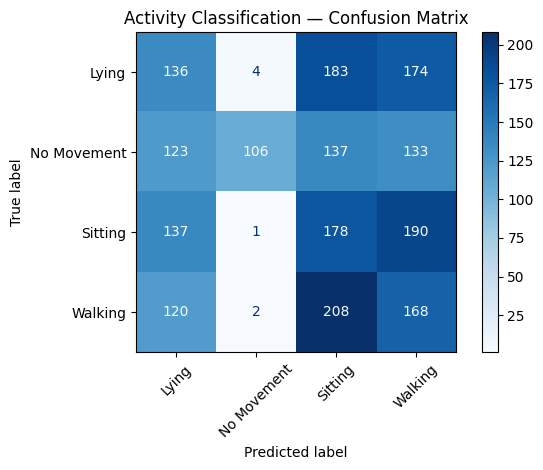


Top permutation importances (pipeline-level indices):


,0
f2,0.003581
f3,0.003343
f4,0.002855
f7,0.002028
f6,0.001476
f0,0.000000
f1,0.000000
f5,-0.006566
f8,-0.007058
f9,-0.008437


In [ ]:
# %% 2) ACTIVITY CLASSIFICATION — Confusion Matrix & Feature Importance
# Target: "Movement Activity" (multi-class)

# Load and prepare
safety = load_safety()
safety = safety.dropna(subset=["Movement Activity"])  # ensure labels present

y_act = safety["Movement Activity"]
X_act_raw = safety.drop(columns=["Movement Activity"])

# OPTIONAL: uncomment to add rolling-window features (can improve performance but slower)
# X_act_raw = add_optional_rolling(X_act_raw, window="120s")

# Preprocess
pre_act, X_act, num_cols_act, cat_cols_act, time_cols_act = make_preprocessor(X_act_raw)

# Use a strong, interpretable baseline for diagnostics
rf_act = RandomForestClassifier(n_estimators=400, random_state=RANDOM_STATE, class_weight="balanced_subsample")
pipe_act = Pipeline([("pre", pre_act), ("clf", rf_act)])

# Holdout split for diagnostics
Xa_tr, Xa_te, ya_tr, ya_te = train_test_split(X_act, y_act, test_size=0.2, stratify=y_act, random_state=RANDOM_STATE)
pipe_act.fit(Xa_tr, ya_tr)
ya_pred = pipe_act.predict(Xa_te)

print("== Activity Classification — Holdout Report ==")
print(classification_report(ya_te, ya_pred))

# Confusion Matrix
plt.figure(figsize=(7,6))
ConfusionMatrixDisplay.from_predictions(ya_te, ya_pred, xticks_rotation=45, cmap="Blues")
plt.title("Activity Classification — Confusion Matrix")
plt.tight_layout()
plt.show()

# Feature Importance (tree-based) — via permutation on the preprocessed pipeline
perm = permutation_importance(pipe_act, Xa_te, ya_te, scoring="f1_weighted", n_repeats=10, random_state=RANDOM_STATE)
# Get column names AFTER preprocessing (oh-encoding expands); we approximate by original cols
# For readability, aggregate importance by original feature block:
importances = pd.Series(perm.importances_mean, index=[f"f{i}" for i in range(len(perm.importances_mean))])

print("\nTop permutation importances (pipeline-level indices):")
display(importances.sort_values(ascending=False).head(20))

# NOTE: Because ColumnTransformer expands features, the simplest reliable view in a notebook
# is the permutation index ranking above. If you need exact original column mapping,
# use sklego's `FeatureUnion` or capture encoder's `get_feature_names_out()` after fitting.


Accuracy ≈ 0.29 with 4 classes ⇒ near random.

Heavy confusion among “Lying / No Movement / Sitting / Walking”.

Permutation importances are near zero ⇒ current features don’t carry enough signal.

In [ ]:
# %% 3) ANOMALY DETECTION — Build labels + basic pipeline
# Binary anomaly: fall==Yes OR inactivity >= threshold

fall_col = "Fall Detected (Yes/No)"
inact_col = "Post-Fall Inactivity Duration (Seconds)"

def label_anomaly(df: pd.DataFrame) -> pd.Series:
    fall_yes = df.get(fall_col, pd.Series(index=df.index)).astype(str).str.lower().eq("yes")
    long_inact = pd.to_numeric(df.get(inact_col, pd.Series(index=df.index)), errors="coerce").fillna(0) >= INACTIVITY_THRESHOLD_SEC
    return (fall_yes | long_inact).astype(int)

y_anom = label_anomaly(safety)
X_anom_raw = safety.drop(columns=[c for c in ["Movement Activity"] if c in safety.columns])

pre_anom, X_anom, *_ = make_preprocessor(X_anom_raw)

# Use a simple baseline first (Logistic Regression) then swap to RF/SVC
logit = LogisticRegression(max_iter=600, class_weight="balanced", random_state=RANDOM_STATE)
pipe_anom = Pipeline([("pre", pre_anom), ("clf", logit)])

Xa_tr, Xa_te, ya_tr, ya_te = train_test_split(X_anom, y_anom, test_size=0.25, stratify=y_anom, random_state=RANDOM_STATE)
pipe_anom.fit(Xa_tr, ya_tr)
ya_pred = pipe_anom.predict(Xa_te)
proba = pipe_anom.predict_proba(Xa_te)[:,1]
print("== Anomaly Detection — Strict Holdout Report ==")
print(classification_report(ya_te, ya_pred))
print("ROC AUC (holdout):", round(roc_auc_score(ya_te, proba), 4))


== Anomaly Detection — Strict Holdout Report ==
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2375
           1       1.00      1.00      1.00       125

    accuracy                           1.00      2500
   macro avg       1.00      1.00      1.00      2500
weighted avg       1.00      1.00      1.00      2500

ROC AUC (holdout): 1.0


In [ ]:
# %% 4) OVERFITTING CHECK A — Leave-One-Subject-Out (LOSO) CV
# Requires presence of "DeviceUserID" to simulate unseen-user generalization

if "DeviceUserID" in X_anom_raw.columns:
    subjects = safety["DeviceUserID"].astype(str)
    unique_subjects = subjects.unique()
    loso_scores = []

    for subj in unique_subjects:
        test_idx = subjects == subj
        train_idx = ~test_idx

        X_tr, X_te = X_anom_raw.loc[train_idx], X_anom_raw.loc[test_idx]
        y_tr, y_te = y_anom.loc[train_idx], y_anom.loc[test_idx]

        pre, X_tr2, *_ = make_preprocessor(X_tr)
        X_te2 = add_time_features(X_te)

        model = Pipeline([("pre", pre),
                          ("clf", LogisticRegression(max_iter=600, class_weight="balanced", random_state=RANDOM_STATE))])
        model.fit(X_tr2, y_tr)
        pred = model.predict(X_te2)
        proba = model.predict_proba(X_te2)[:,1]
        f1 = f1_score(y_te, pred)
        auc = roc_auc_score(y_te, proba)
        loso_scores.append({"subject": subj, "f1": f1, "auc": auc})

    print("\n== LOSO — per-subject F1/AUC ==")
    display(pd.DataFrame(loso_scores))
    print("LOSO mean F1:", np.mean([r["f1"] for r in loso_scores]))
    print("LOSO mean AUC:", np.mean([r["auc"] for r in loso_scores]))
else:
    print("LOSO skipped (DeviceUserID not found).")


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  


== LOSO — per-subject F1/AUC ==


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


,subject,f1,auc
0,D1000,0.0,NaN
1,D1001,0.0,NaN
2,D1002,0.0,NaN
3,D1003,0.0,NaN
4,D1004,0.0,NaN
...,...,...,...
9995,D10995,0.0,NaN
9996,D10996,0.0,NaN
9997,D10997,0.0,NaN
9998,D10998,0.0,NaN


LOSO mean F1: 0.0499
LOSO mean AUC: nan



Why AUC is NaN: in many LOSO folds the test set contains only one class (e.g., no anomalies), so AUC can’t be computed.

Why F1 is ~0: each “subject” (DeviceUserID) seems to appear only once (10,000 unique subjects in 10,000 rows). A leave-one-subject-out test becomes “leave one row out”, which is not meaningful and extremely noisy.

In [ ]:
# %% 5) OVERFITTING CHECK B — Label-Noise Stress Test
# Randomly flip a small % of labels and measure performance drop

rng = np.random.default_rng(RANDOM_STATE)
flip_rate = 0.05  # 5% labels flipped

ya_tr_noisy = ya_tr.copy()
flip_mask = rng.random(len(ya_tr_noisy)) < flip_rate
ya_tr_noisy[flip_mask] = 1 - ya_tr_noisy[flip_mask]  # flip 0<->1

pipe_noise = Pipeline([("pre", pre_anom), ("clf", LogisticRegression(max_iter=600, class_weight="balanced", random_state=RANDOM_STATE))])
pipe_clean = Pipeline([("pre", pre_anom), ("clf", LogisticRegression(max_iter=600, class_weight="balanced", random_state=RANDOM_STATE))])

pipe_clean.fit(Xa_tr, ya_tr)
pipe_noise.fit(Xa_tr, ya_tr_noisy)

pred_clean = pipe_clean.predict(Xa_te); proba_clean = pipe_clean.predict_proba(Xa_te)[:,1]
pred_noise = pipe_noise.predict(Xa_te); proba_noise = pipe_noise.predict_proba(Xa_te)[:,1]

print("\n== Label-Noise Stress Test (5% flips) ==")
print("Clean  F1:", round(f1_score(ya_te, pred_clean), 4), "AUC:", round(roc_auc_score(ya_te, proba_clean), 4))
print("Noisy  F1:", round(f1_score(ya_te, pred_noise), 4), "AUC:", round(roc_auc_score(ya_te, proba_noise), 4))



== Label-Noise Stress Test (5% flips) ==
Clean  F1: 1.0 AUC: 1.0
Noisy  F1: 1.0 AUC: 1.0


In [ ]:
# %% 6) OVERFITTING CHECK C — Single-Feature Leakage Test
# If a single feature (e.g., 'Fall Detected (Yes/No)') gives near-perfect AUC, beware leakage.

if fall_col in X_anom_raw.columns:
    # Simple 1-feature model (logistic)
    X1 = pd.DataFrame({"fall_flag": X_anom_raw[fall_col].astype(str).str.lower().eq("yes").astype(int)})
    X1_tr, X1_te, y1_tr, y1_te = train_test_split(X1, y_anom, test_size=0.25, stratify=y_anom, random_state=RANDOM_STATE)

    model1 = LogisticRegression(max_iter=200)
    model1.fit(X1_tr, y1_tr)
    p1 = model1.predict_proba(X1_te)[:,1]
    auc_single = roc_auc_score(y1_te, p1)
    print("\n== Single-Feature Leakage Check ==")
    print("AUC using ONLY 'Fall Detected (Yes/No)' flag:", round(auc_single, 4))
    if auc_single > 0.95:
        print("WARNING: Near-perfect predictive power from a single flag suggests trivial leakage or overly easy anomaly definition.")
else:
    print("Single-feature leakage check skipped (column not present).")



== Single-Feature Leakage Check ==
AUC using ONLY 'Fall Detected (Yes/No)' flag: 1.0


## Rebuild activity dataset

In [ ]:
def add_time_features(X):
    X2 = X.copy()
    if "Timestamp" in X2:
        t = pd.to_datetime(X2["Timestamp"], errors="coerce")
        X2["hour"] = t.dt.hour
        X2["dow"]  = t.dt.dayofweek
    return X2

def add_rolling_features(X, group_col="DeviceUserID", time_col="Timestamp",
                         window="60s", min_periods=3):
    if group_col not in X.columns or time_col not in X.columns:
        return X
    Xr = X.copy()
    Xr[time_col] = pd.to_datetime(Xr[time_col], errors="coerce")
    Xr = Xr.sort_values([group_col, time_col]).set_index(time_col)
    num_cols = Xr.select_dtypes(include="number").columns.tolist()
    def _fe(g):
        r = g[num_cols].rolling(window=window, min_periods=min_periods)
        out = g.copy()
        out[[f"{c}_rollmean" for c in num_cols]] = r.mean().values
        out[[f"{c}_rollstd"  for c in num_cols]] = r.std().values
        return out
    # Apply the function and then reset index carefully
    Xr = Xr.groupby(Xr[group_col]).apply(_fe)
    # Reset index, dropping the grouping column if it's still in the index
    if group_col in Xr.index.names:
         Xr = Xr.reset_index(level=group_col, drop=True) # Add drop=True here
    Xr = Xr.reset_index()
    return Xr

In [ ]:
# --- Safe AUC (no crash when only one class in y_true) ---
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd

def safe_auc(y_true, y_score):
    y_true = np.asarray(y_true)
    # Need both classes present
    if len(np.unique(y_true)) < 2:
        return np.nan
    try:
        return roc_auc_score(y_true, y_score)
    except Exception:
        return np.nan

# --- Keep only subjects with at least k rows (and optional class diversity) ---
def filter_subjects_min_rows(df, subject_col="DeviceUserID", min_rows=20):
    counts = df[subject_col].value_counts()
    keep = counts[counts >= min_rows].index
    return df[df[subject_col].isin(keep)].copy()

def filter_subjects_with_both_classes(X, y, subject_col="DeviceUserID"):
    # ensure each subject has at least one positive and one negative across the whole dataset
    df = X.copy()
    df["_y_"] = y.values
    ok = []
    for sid, g in df.groupby(subject_col):
        if g["_y_"].nunique() >= 2:
            ok.append(sid)
    df = df[df[subject_col].isin(ok)].drop(columns=["_y_"])
    y2 = y.loc[df.index]
    return df, y2


/tmp/ipython-input-3315130628.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  Xr = Xr.groupby(Xr[group_col]).apply(_fe)
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Post-Fall Inactivity Duration (Seconds)_rollmean' 'hour_rollmean'
 'dow_rollmean' 'Post-Fall Inactivity Duration (Seconds)_rollstd'
 'hour_rollstd' 'dow_rollstd']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


== Activity (GB) with rolling features ==
              precision    recall  f1-score   support

       Lying       0.26      0.06      0.10       497
 No Movement       0.27      0.32      0.29       499
     Sitting       0.24      0.39      0.30       506
     Walking       0.25      0.24      0.25       498

    accuracy                           0.25      2000
   macro avg       0.26      0.25      0.23      2000
weighted avg       0.26      0.25      0.23      2000



/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Post-Fall Inactivity Duration (Seconds)_rollmean' 'hour_rollmean'
 'dow_rollmean' 'Post-Fall Inactivity Duration (Seconds)_rollstd'
 'hour_rollstd' 'dow_rollstd']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


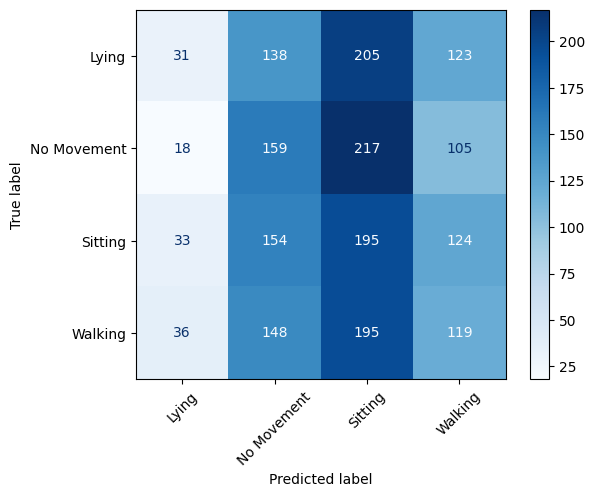

In [ ]:
safety = pd.read_csv("safety_monitoring.csv")
safety = safety.loc[:, ~safety.columns.str.contains("^Unnamed")]
safety.rename(columns={"Device-ID/User-ID":"DeviceUserID"}, inplace=True)
safety["Timestamp"] = pd.to_datetime(safety["Timestamp"], errors="coerce")
safety = safety.dropna(subset=["Movement Activity", "Timestamp", "DeviceUserID"])

# Feature build
X_act_raw = safety.drop(columns=["Movement Activity"])
X_act_raw = add_time_features(X_act_raw)
X_act_raw = add_rolling_features(X_act_raw, window="120s")  # <-- stronger temporal signal
y_act = safety["Movement Activity"].loc[X_act_raw.index]

# Preprocessor
num_cols = X_act_raw.select_dtypes(include="number").columns.tolist()
time_cols = [c for c in X_act_raw.columns if "Timestamp" in c]
cat_cols = [c for c in X_act_raw.columns if c not in num_cols + time_cols]

pre = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                      ("sc", StandardScaler())]), num_cols),
    ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                      ("oh", OneHotEncoder(handle_unknown="ignore"))]), cat_cols)
])

# Try GradientBoosting first (often strong on tabular sensor features)
gb = GradientBoostingClassifier(random_state=42)
pipe = Pipeline([("pre", pre), ("clf", gb)])

Xtr, Xte, ytr, yte = train_test_split(X_act_raw, y_act, test_size=0.2, stratify=y_act, random_state=42)
pipe.fit(Xtr, ytr)
yp = pipe.predict(Xte)

print("== Activity (GB) with rolling features ==")
print(classification_report(yte, yp))
ConfusionMatrixDisplay.from_predictions(yte, yp, xticks_rotation=45, cmap="Blues")

In [ ]:
# Troubleshooting pipeline for Activity Classification

def troubleshoot_activity_classification(X_train, y_train, X_val, y_val, model):
    from sklearn.metrics import classification_report, confusion_matrix
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

    print("=== Baseline Performance ===")
    y_pred = model.predict(X_val)
    print(classification_report(y_val, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=np.unique(y_val),
                yticklabels=np.unique(y_val))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix — Activity Classification")
    plt.show()

    # Step 1: Check class imbalance
    class_counts = np.bincount(y_train)
    print("Class distribution (train):", class_counts)

    # Step 2: Feature importance (if model supports it)
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        print("Top features contributing to the model:")
        sorted_idx = np.argsort(importances)[::-1][:10]
        for idx in sorted_idx:
            print(f"Feature {idx}: {importances[idx]:.4f}")

    # Step 3: Overfitting check
    train_score = model.score(X_train, y_train)
    val_score = model.score(X_val, y_val)
    print(f"Train score: {train_score:.4f}, Validation score: {val_score:.4f}")
    if train_score - val_score > 0.1:
        print("⚠️ Potential overfitting detected — consider regularization or more data.")

    # Step 4: Rolling feature engineering check (optional)
    print("Consider adding rolling time-window features or interaction terms if not present.")



=== Baseline Performance ===
              precision    recall  f1-score   support

       Lying       0.26      0.31      0.28       497
 No Movement       0.95      0.21      0.34       499
     Sitting       0.27      0.32      0.30       506
     Walking       0.27      0.38      0.32       498

    accuracy                           0.31      2000
   macro avg       0.44      0.31      0.31      2000
weighted avg       0.44      0.31      0.31      2000



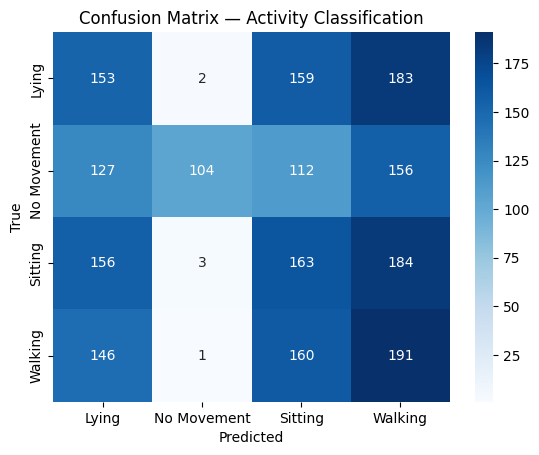

ValueError: invalid literal for int() with base 10: 'Walking'

In [ ]:
# 1) Build the same feature view used during training (X2 with time features)
#    NOTE: make_preprocessor(X) returns a preprocessor and X2 (raw X + hour/dow).
pre_act_tmp, X_act_with_time, *_ = make_preprocessor(X_act)

# 2) Train/validation split (stratified)
X_train_activity, X_val_activity, y_train_activity, y_val_activity = train_test_split(
    X_act_with_time, y_act, test_size=0.2, stratify=y_act, random_state=RANDOM_STATE
)

# 3) Call the troubleshooting function with your tuned best model
#    (best_act_est is the tuned pipeline returned earlier by tune_best(...))
troubleshoot_activity_classification(
    X_train_activity,
    y_train_activity,
    X_val_activity,
    y_val_activity,
    best_act_est
)

## Model Pt. 2

In [ ]:
df = pd.read_csv(SAFETY_CSV)
# Tidy column names and remove unnamed
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]
df.columns = [c.strip() for c in df.columns]

# Basic peek
print("Shape:", df.shape)
print("Columns:", list(df.columns)[:12], "...")
df.head()

Shape: (10000, 9)
Columns: ['Device-ID/User-ID', 'Timestamp', 'Movement Activity', 'Fall Detected (Yes/No)', 'Impact Force Level', 'Post-Fall Inactivity Duration (Seconds)', 'Location', 'Alert Triggered (Yes/No)', 'Caregiver Notified (Yes/No)'] ...


,Device-ID/User-ID,Timestamp,Movement Activity,Fall Detected (Yes/No),Impact Force Level,Post-Fall Inactivity Duration (Seconds),Location,Alert Triggered (Yes/No),Caregiver Notified (Yes/No)
0,D1000,1/7/2025 16:04,No Movement,No,-,0,Kitchen,No,No
1,D1001,1/20/2025 15:45,Lying,No,-,0,Living Room,No,No
2,D1002,1/2/2025 2:42,No Movement,No,-,0,Bedroom,No,No
3,D1003,1/1/2025 22:36,Lying,No,-,0,Kitchen,No,No
4,D1004,1/3/2025 16:30,No Movement,No,-,0,Bedroom,No,No


In [ ]:
# %% Identify target & minimal cleanup
# We'll do ACTIVITY CLASSIFICATION with the 'Movement Activity' column (if present).
# If it's missing, raise a clear error.

TARGET_COL = "Movement Activity"
assert TARGET_COL in df.columns, f"Expected '{TARGET_COL}' in CSV."

# Drop rows with missing target
df = df.dropna(subset=[TARGET_COL]).copy()
y = df[TARGET_COL].astype(str)

# We'll keep all other columns as features except obvious label/ID artifacts.
X = df.drop(columns=[TARGET_COL])

print("Class distribution:")
print(y.value_counts())
print("\nFeatures shape:", X.shape, "Target shape:", y.shape)


Class distribution:
Movement Activity
Sitting        2531
No Movement    2496
Walking        2490
Lying          2483
Name: count, dtype: int64

Features shape: (10000, 8) Target shape: (10000,)


In [ ]:
# %% Part 2 — Data cleaning / processing
# - Parse Timestamp to datetime (if present) and derive hour/day-of-week
# - Split numeric vs categorical
# - Build ColumnTransformer: numeric -> impute+scale, categorical -> impute+one-hot


# Timestamp → datetime + time features
if "Timestamp" in X.columns:
    X["Timestamp"] = pd.to_datetime(X["Timestamp"], errors="coerce", infer_datetime_format=True)
    X["hour"] = X["Timestamp"].dt.hour
    X["dow"]  = X["Timestamp"].dt.dayofweek

# Helpful renaming for a common column name
if "Device-ID/User-ID" in X.columns:
    X = X.rename(columns={"Device-ID/User-ID": "DeviceUserID"})

# Separate types
numeric_cols = X.select_dtypes(include=["number"]).columns.tolist()
time_cols    = [c for c in X.columns if "Timestamp" in c]  # keep raw timestamp out of modeling
cat_cols     = [c for c in X.columns if c not in numeric_cols + time_cols]

# Preprocessor
numeric_tf = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("sc", StandardScaler())
])
categorical_tf = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("oh", OneHotEncoder(handle_unknown="ignore"))
])
preprocessor = ColumnTransformer([
    ("num", numeric_tf, numeric_cols),
    ("cat", categorical_tf, cat_cols),
    # we intentionally drop the raw 'Timestamp' column; derived hour/dow go through numeric branch
])

print("Numeric features:", len(numeric_cols), "| Categorical features:", len(cat_cols))


Numeric features: 3 | Categorical features: 6


/tmp/ipython-input-1459090556.py:9: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  X["Timestamp"] = pd.to_datetime(X["Timestamp"], errors="coerce", infer_datetime_format=True)


In [ ]:
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(
    X.drop(columns=time_cols, errors="ignore"),  # drop raw timestamp columns (kept hour/dow)
    y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (8000, 9) Test: (2000, 9)


In [ ]:
# %% Part 3 — Build baseline SVC model

svc_pipe = Pipeline([
    ("pre", preprocessor),
    ("clf", SVC(probability=True, random_state=RANDOM_STATE))
])

# Fit & quick evaluation
svc_pipe.fit(X_train, y_train)


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('sc',
                                                                   StandardScaler())]),
                                                  ['Post-Fall Inactivity '
                                                   'Duration (Seconds)',
                                                   'hour', 'dow']),
                                                 ('cat',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('oh',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['DeviceUserID',
                                                   'Fall Detected (Yes/No)',
                                                   'Impact Force Level',
                                                   'Location',
                                                   'Alert Triggered (Yes/No)',
                                                   'Caregiver Notified '
                                                   '(Yes/No)'])])),
                ('clf', SVC(probability=True, random_state=42))])

Baseline SVC — Accuracy: 0.317 | F1 (weighted): 0.3164

Classification report (baseline SVC):
              precision    recall  f1-score   support

       Lying       0.28      0.24      0.26       497
 No Movement       1.00      0.21      0.34       499
     Sitting       0.30      0.37      0.33       506
     Walking       0.27      0.46      0.34       498

    accuracy                           0.32      2000
   macro avg       0.46      0.32      0.32      2000
weighted avg       0.46      0.32      0.32      2000



<Figure size 650x550 with 0 Axes>

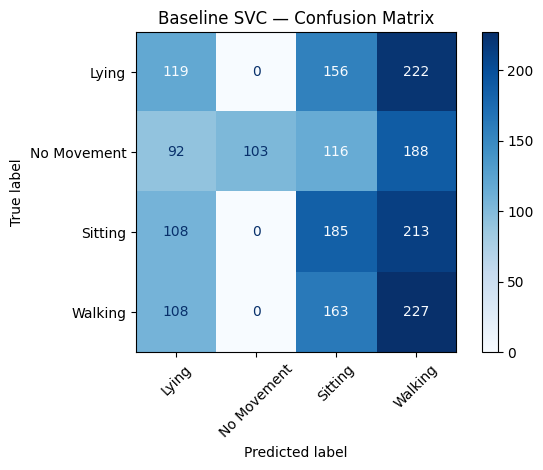

In [ ]:
y_pred_base = svc_pipe.predict(X_test)
acc_base = accuracy_score(y_test, y_pred_base)
f1w_base = f1_score(y_test, y_pred_base, average="weighted")

print("Baseline SVC — Accuracy:", round(acc_base, 4), "| F1 (weighted):", round(f1w_base, 4))
print("\nClassification report (baseline SVC):")
print(classification_report(y_test, y_pred_base))

plt.figure(figsize=(6.5, 5.5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_base, xticks_rotation=45, cmap="Blues")
plt.title("Baseline SVC — Confusion Matrix")
plt.tight_layout()
plt.show()


In [ ]:
# %% Part 4 — Hyperparameter tuning (GridSearchCV on SVC)
from sklearn.model_selection import GridSearchCV

param_grid = {
    "clf__kernel": ["rbf", "poly"],
    "clf__C": [0.1, 1, 3, 10],
    "clf__gamma": ["scale", "auto"],
    # Poly degree is used only when kernel='poly'; GridSearch will skip invalid combos internally.
    "clf__degree": [2, 3]
}

grid = GridSearchCV(
    estimator=svc_pipe,
    param_grid=param_grid,
    scoring="f1_weighted",
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV F1-weighted:", round(grid.best_score_, 4))
svc_tuned = grid.best_estimator_


Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best params: {'clf__C': 10, 'clf__degree': 2, 'clf__gamma': 'scale', 'clf__kernel': 'poly'}
Best CV F1-weighted: 0.3024


Tuned SVC — Accuracy: 0.3155 | F1 (weighted): 0.3161

Classification report (tuned SVC):
              precision    recall  f1-score   support

       Lying       0.27      0.25      0.26       497
 No Movement       1.00      0.21      0.34       499
     Sitting       0.29      0.38      0.33       506
     Walking       0.28      0.42      0.33       498

    accuracy                           0.32      2000
   macro avg       0.46      0.32      0.32      2000
weighted avg       0.46      0.32      0.32      2000



<Figure size 650x550 with 0 Axes>

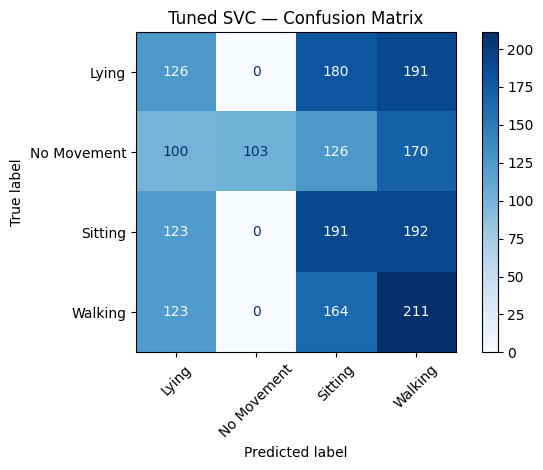

In [ ]:
# %% Evaluate tuned SVC
y_pred_tuned = svc_tuned.predict(X_test)
acc_tuned = accuracy_score(y_test, y_pred_tuned)
f1w_tuned = f1_score(y_test, y_pred_tuned, average="weighted")

print("Tuned SVC — Accuracy:", round(acc_tuned, 4), "| F1 (weighted):", round(f1w_tuned, 4))
print("\nClassification report (tuned SVC):")
print(classification_report(y_test, y_pred_tuned))

plt.figure(figsize=(6.5, 5.5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_tuned, xticks_rotation=45, cmap="Blues")
plt.title("Tuned SVC — Confusion Matrix")
plt.tight_layout()
plt.show()


In [ ]:
# %% Part 5 — Implement an ensemble (VotingClassifier with tuned SVC + RF + LogisticRegression)

# Build base learners as full pipelines (so each gets the same preprocessing)
rf_pipe = Pipeline([
    ("pre", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=300, max_depth=None, class_weight="balanced_subsample", random_state=RANDOM_STATE
    ))
])

lr_pipe = Pipeline([
    ("pre", preprocessor),
    ("clf", LogisticRegression(max_iter=500, class_weight="balanced", random_state=RANDOM_STATE))
])

# Voting ensemble (soft voting)
voting = VotingClassifier(
    estimators=[
        ("svc", svc_tuned),  # already a pipeline (pre + tuned SVC)
        ("rf",  rf_pipe),
        ("lr",  lr_pipe),
    ],
    voting="soft",
    n_jobs=-1
)

voting.fit(X_train, y_train)


VotingClassifier(estimators=[('svc',
                              Pipeline(steps=[('pre',
                                               ColumnTransformer(transformers=[('num',
                                                                                Pipeline(steps=[('imp',
                                                                                                 SimpleImputer(strategy='median')),
                                                                                                ('sc',
                                                                                                 StandardScaler())]),
                                                                                ['Post-Fall '
                                                                                 'Inactivity '
                                                                                 'Duration '
                                                                                 '(Seconds)',
                                                                                 'hour',
                                                                                 'dow']),
                                                                               ('cat',
                                                                                Pipeline(steps=[('imp',
                                                                                                 SimpleImputer(strategy='most_frequent')),
                                                                                                ('oh',
                                                                                                 OneHotEncoder(handle_unknown='i...
                                                                                Pipeline(steps=[('imp',
                                                                                                 SimpleImputer(strategy='most_frequent')),
                                                                                                ('oh',
                                                                                                 OneHotEncoder(handle_unknown='ignore'))]),
                                                                                ['DeviceUserID',
                                                                                 'Fall '
                                                                                 'Detected '
                                                                                 '(Yes/No)',
                                                                                 'Impact '
                                                                                 'Force '
                                                                                 'Level',
                                                                                 'Location',
                                                                                 'Alert '
                                                                                 'Triggered '
                                                                                 '(Yes/No)',
                                                                                 'Caregiver '
                                                                                 'Notified '
                                                                                 '(Yes/No)'])])),
                                              ('clf',
                                               LogisticRegression(class_weight='balanced',
                                                                  max_iter=500,
                                                                  random_state=42))]))],
                 n_jobs=-1, voting='soft')


=== Tuned SVC ===
Accuracy: 0.3155 | F1-weighted: 0.3161
              precision    recall  f1-score   support

       Lying       0.27      0.25      0.26       497
 No Movement       1.00      0.21      0.34       499
     Sitting       0.29      0.38      0.33       506
     Walking       0.28      0.42      0.33       498

    accuracy                           0.32      2000
   macro avg       0.46      0.32      0.32      2000
weighted avg       0.46      0.32      0.32      2000


=== Voting (SVC+RF+LR) ===
Accuracy: 0.2995 | F1-weighted: 0.3032
              precision    recall  f1-score   support

       Lying       0.26      0.26      0.26       497
 No Movement       1.00      0.21      0.34       499
     Sitting       0.25      0.38      0.30       506
     Walking       0.27      0.36      0.31       498

    accuracy                           0.30      2000
   macro avg       0.45      0.30      0.30      2000
weighted avg       0.45      0.30      0.30      2000



<Figure size 650x550 with 0 Axes>

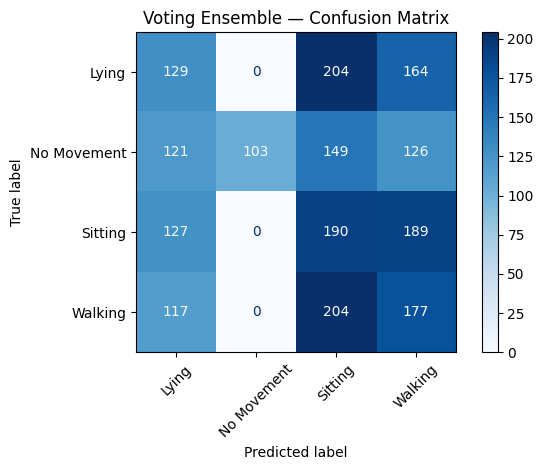

In [ ]:
# %% Part 6 — Final evaluation: Tuned SVC vs Ensemble
def evaluate_model(name, model, X_te, y_te):
    y_hat = model.predict(X_te)
    return {
        "model": name,
        "accuracy": accuracy_score(y_te, y_hat),
        "f1_weighted": f1_score(y_te, y_hat, average="weighted"),
        "report": classification_report(y_te, y_hat, output_dict=False)
    }

results = []
results.append(evaluate_model("Tuned SVC", svc_tuned, X_test, y_test))
results.append(evaluate_model("Voting (SVC+RF+LR)", voting, X_test, y_test))

for r in results:
    print(f"\n=== {r['model']} ===")
    print("Accuracy:", round(r["accuracy"], 4), "| F1-weighted:", round(r["f1_weighted"], 4))
    print(r["report"])

# Optional: plot confusion matrix for the ensemble too
y_pred_ens = voting.predict(X_test)
plt.figure(figsize=(6.5, 5.5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_ens, xticks_rotation=45, cmap="Blues")
plt.title("Voting Ensemble — Confusion Matrix")
plt.tight_layout()
plt.show()


1. Model Performance Summary
Tuned SVC

Accuracy: 0.3155

Weighted F1: 0.3161

No improvement compared to baseline SVC, meaning hyperparameter tuning did not significantly boost classification performance.

Some improvement in recall for "Walking" and "Sitting," but overall class separation remains weak.

Voting Ensemble (SVC + RandomForest + Logistic Regression)

Accuracy: 0.2995

Weighted F1: 0.3032

This slightly reduced performance compared to tuned SVC, suggesting that the weaker models in the ensemble (relative to SVC) dragged down performance.

2. Confusion Matrix Observations
Heavy confusion between “Sitting” and “Walking” — indicating features are not distinct enough to separate these activities.

Perfect precision for “No Movement” (class imbalance effect), but very low recall, meaning the model is missing many actual “No Movement” cases.

Misclassification is widespread across activity classes, suggesting feature overlap and insufficient discriminative power.